This notebook is a fork of https://colab.research.google.com/drive/1aJil6wmaef_EZ-eCS8T4WuqD2AiFNHkv?usp=sharing

In [1]:
!pip install -U -q keras-nlp --no-deps

# Imports

Let's important Keras, KerasNLP and some helper. Remember to set the backend before you import!

In [2]:
import os
# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
import keras
import keras_nlp
import numpy as np
import PIL
import requests
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

2024-05-24 05:51:15.706934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 05:51:15.707073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 05:51:15.832851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
keras.__version__

'3.2.1'

In [5]:
keras_nlp.__version__

'0.12.1'

In [6]:
keras.config.backend()

'jax'

# Helper Functions

In [7]:
def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))


def read_image(url, target_size):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image


def parse_bbox_and_labels(detokenized_output: str):
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        " (?P<label>.+?)( ;|$)",
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d["y0"]), fmt(d["x0"]), fmt(d["y1"]), fmt(d["x1"])])
        labels.append(d["label"])
    return np.array(boxes), np.array(labels)


def display_boxes(image, boxes, labels, target_image_size):
    h, l = target_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(boxes.shape[0]):
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"
        )
        # Add label
        plt.text(x, y, labels[i], color="red", fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


# Load the model from Kaggle Models

Now we can load the PaliGemma "causal language model" from the Kaggle Models hub. A causal language model is just a LLM that is ready for generation, by training with a causal mask, and running generation a token at a time in a recurrent loop.

In [8]:
keras.config.set_floatx("bfloat16")

In [9]:
pali_gemma_lm = keras_nlp.models.PaliGemmaCausalLM.from_preset(
    "pali_gemma_3b_mix_224"
)
pali_gemma_lm.summary()

Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/paligemma/keras/pali_gemma_3b_mix_224/1' to your Kaggle notebook...

Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)          │                                             257,152 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (5.45 GB)

 Trainable params: 2,923,335,408 (5.45 GB)

 Non-trainable params: 0 (0.00 B)

# Test PaliGemma Inference

We can now load a test image and start query it with the model.

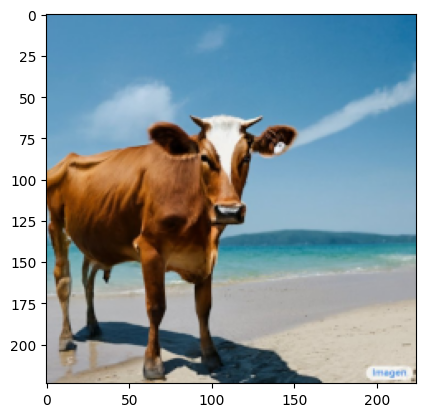

In [10]:
# Crop the image to the desired dimensions.
target_size = (224, 224)
image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
image = read_image(image_url, target_size)
plt.imshow(image)

Here's a generation call with a single image and prompt. The prompt should always end with `\n`.

In [11]:
prompt = 'answer en where is the cow standing?\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)

answer en where is the cow standing?
beach


Here is a object detection example

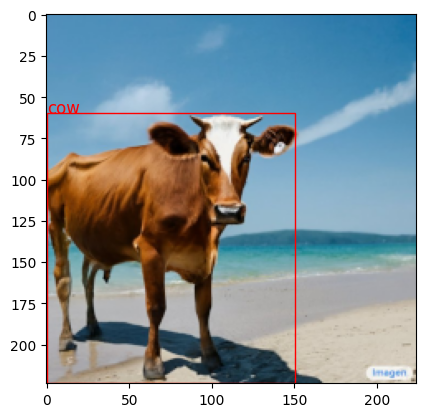

In [12]:
prompt = 'detect cow\n'
output = pali_gemma_lm.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(image, boxes, labels, target_size)

Here's a generation call with batched inputs.

In [13]:
prompts = [
    'answer en where is the cow standing?\n',
    'answer en what color is the cow?\n',
    'describe en\n',
    'detect cow\n',
    'segment cow\n',
]
images = [image, image, image, image, image]
outputs = pali_gemma_lm.generate(
    inputs={
        "images": images,
        "prompts": prompts,
    }
)
for output in outputs:
    print(output)

answer en where is the cow standing?
beach
answer en what color is the cow?
brown
describe en
A brown cow stands on the wet sand at the beach, its head resting on its legs. The sky is clear and blue with a few white clouds. The water is blue and the waves are crashing gently against the shore. The cow's horns are sharp and its eyes are bright. The sand is wet and the waves are rolling. The cow's shadow is cast on the sand. The cow's ear has a tag in it. The cow is standing on the sand, its front legs extended.
detect cow
<loc0274><loc0000><loc1022><loc0688> cow
segment cow
<loc0278><loc0000><loc1012><loc0686><seg028><seg051><seg116><seg113><seg007><seg065><seg057><seg023><seg081><seg126><seg019><seg093><seg016><seg102><seg003><seg068>


There's a few other style of prompts this model can handle out of the box...

- `"cap {lang}\n"`: very raw short caption (from WebLI-alt).
- `"caption {lang}\n"`: nice, coco-like short captions.
- `"describe {lang}\n"`: somewhat longer more descriptive captions.
- `"ocr\n"`: optical character recognition.
- `"answer en {question}\n"`: question answering about the image contents.
- `"question {lang} {answer}\n"`: question generation for a given answer.
- `"detect {thing} ; {thing}\n"`: count objects in a scene.

Try them out!